# **<font color=coral> DM search**

## **1. <font color=navy> Imports**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install dependencies
# %pip install umap-learn
# %pip install plotly
# %pip install wpca
# %pip install -U scikit-learn

In [1]:
# general imports
import random
import numpy as np
import pandas as pd
import ipywidgets as widgets  # to create interactive elements within the notebook

# visualisation tools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

# dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#from umap import UMAP
#from wpca import WPCA

# ML inventory
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

seed = 84

## **2. <font color=navy> Data setup**

In [ ]:
#@title <font color="royalblue">*Choose*</font> a DM model
DM_mass = widgets.ToggleButtons(options=[10,100,200,300,400,500,600,700,800,2000], value=300, description='DM, GeV:', button_style='info')
DM_mass

ToggleButtons(button_style='info', description='DM, GeV:', index=3, options=(10, 100, 200, 300, 400, 500, 600,…

In [ ]:
#@title <font color="royalblue">*Run*</font>  the cell to build and preview a data set (2021)
# make a list of all background processes
processes = ['Non-resonant_ll', 'Z+jets', 'WZ', 'ZZ'] # for 2021 data

# import all bacjground in a data set
df_2021 = pd.DataFrame()
for process in processes:
    df = pd.read_csv(f'https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/csv/DM_ML_notebook/{process}.csv')
    df.insert(loc=0, column='Event', value=process)
    df_2021 = pd.concat([df_2021,df], ignore_index=True)
    del df

# pick up respective DM data set (2021)
DM = 'DM_'+str(DM_mass.value)
df_DM = pd.read_csv(f'https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/csv/DM_ML_notebook/{DM}.csv')
df_DM.insert(loc=0, column='Event', value=DM)

# add DM to the background data set
df_2021 = pd.concat([df_2021,df_DM], ignore_index=True)

# preview the final data set
df_2021

In [ ]:
#@title <font color="royalblue">*Run*</font>  the cell to build and preview a data set (2022)
# make a list of all background processes
processes = ['nonresll', 'Zjets', 'WZ', 'ZZ'] # for 2022 data

# import all bacjground in a data set
df_2022 = pd.DataFrame()
for process in processes:
    df = pd.read_csv(f'https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/csv/DM_ML_workbook/{process}.csv')
    if process=='nonresll':
        name='Non-resonant_ll'
    elif process=='Zjets':
        name='Z+jets'
    else:
        name=process
    df.insert(loc=0, column='Event', value=name)
    df_2022 = pd.concat([df_2022,df], ignore_index=True)
    del df

# pick up respective DM data set (2021)
DM = 'DM_'+str(DM_mass.value)
df_DM = pd.read_csv(f'https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/csv/DM_ML_workbook/{DM}.csv')
df_DM.insert(loc=0, column='Event', value=DM)

# add DM to the background data set
df_2022 = pd.concat([df_2022,df_DM], ignore_index=True)

# preview the final data set
df_2022

,Event,totalWeight,sum_lep_charge,lead_lep_pt,sublead_lep_pt,mll,ETmiss,dRll,dphi_pTll_ETmiss,fractional_pT_difference,ETmiss_over_HT,N_bjets
0,Non-resonant_ll,0.159145,0,67.002844,47.747617,162.595187,30.868574,3.503712,0.387444,1.940903,0.157878,0
1,Non-resonant_ll,0.119856,0,80.983930,26.300879,131.307662,27.798332,3.345649,0.997628,0.209964,0.082891,0
2,Non-resonant_ll,0.134960,0,52.197133,41.386359,107.636395,149.983188,2.633914,0.492760,0.221260,0.503887,0
3,Non-resonant_ll,0.136371,0,125.837844,32.481412,126.265117,62.741371,2.027446,2.086708,0.128302,0.210723,0
4,Non-resonant_ll,0.046193,0,104.523156,51.190152,146.090607,63.217543,3.004501,2.626075,0.324849,0.292518,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1232350,DM_300,0.074409,0,150.121609,30.050945,94.105387,178.817719,1.308371,0.013414,0.005881,0.992480,0
1232351,DM_300,0.079192,0,157.676344,76.896227,129.955672,225.086422,1.158179,2.999638,0.015461,0.772320,0
1232352,DM_300,0.073187,0,94.828984,45.348254,90.757753,127.364039,1.360179,3.128948,0.014387,0.908593,0
1232353,DM_300,0.077624,0,121.088344,37.106082,90.977416,162.607063,1.432372,3.068947,0.195871,1.027894,0


In [ ]:
# #save focus data for further easy access
# df_2022.to_csv('/content/drive/My Drive/Diss modelling/df_2022.csv', index=False)

In [3]:
# from colab
#df_2021 = pd.read_csv('/content/drive/My Drive/Diss modelling/df_2021.csv',index_col=None)
df_2022 = pd.read_csv('/content/drive/My Drive/Diss modelling/df_2022.csv',index_col=None)

In [2]:
# from jupyter
#df_2021 = pd.read_csv('G:/My Drive/Diss modelling/df_2021.csv',index_col=None)
df_2022 = pd.read_csv('G:/My Drive/Diss modelling/df_2022.csv',index_col=None)

## **3. <font color=navy> Data set selection and exploration**

In [3]:
# define features
Feats = df_2022.drop(columns=['Event','totalWeight']).columns
# set a palette
Palette={'Non-resonant_ll':'lightblue','Z+jets':'salmon','WZ':'lightgreen','ZZ':'wheat','DM_300':'navy'}

In [ ]:
#@title <font color="royalblue">*Check*</font> statistics
df_2022.describe().round(3)

,totalWeight,sum_lep_charge,lead_lep_pt,sublead_lep_pt,mll,ETmiss,dRll,dphi_pTll_ETmiss,fractional_pT_difference,ETmiss_over_HT,N_bjets
count,1232355.000,1232355.000,1232355.000,1232355.000,1232355.000,1232355.000,1232355.000,1232355.000,1232355.000,1232355.000,1232355.0
mean,0.013,0.023,83.063,46.442,116.601,67.679,2.277,1.573,0.576,0.344,0.0
std,0.038,0.504,56.669,26.111,79.945,56.051,0.855,1.037,4.006,0.251,0.0
min,-2.682,-2.000,25.203,20.011,7.056,0.049,0.204,0.000,0.000,0.000,0.0
25%,0.001,0.000,50.210,31.341,85.559,33.648,1.649,0.572,0.054,0.160,0.0
50%,0.003,0.000,66.263,38.985,92.150,54.859,2.387,1.575,0.156,0.286,0.0
75%,0.010,0.000,95.288,51.661,125.822,85.183,2.933,2.573,0.409,0.468,0.0
max,0.981,2.000,1879.344,1003.680,3272.575,4521.074,5.707,3.142,1783.602,18.105,0.0


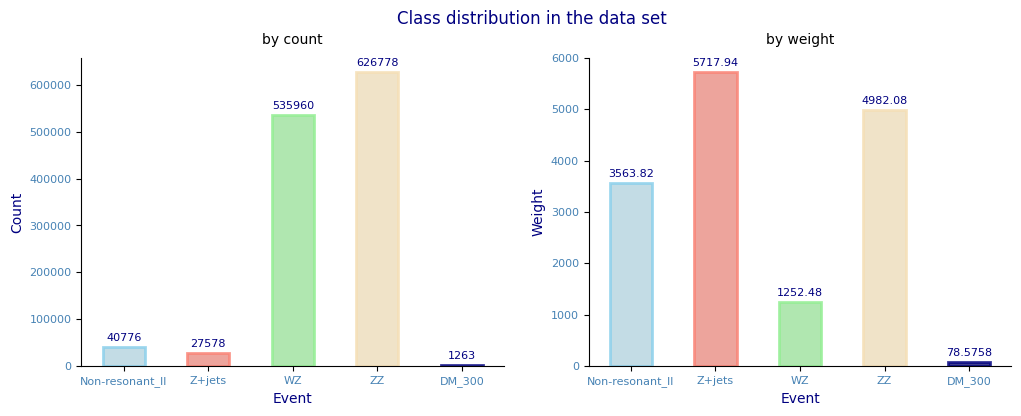

In [ ]:
#@title <font color="royalblue">*Illustrate*</font> the sample distribution across the events (2022)

# plot class distribution in the training set
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Class distribution in the data set', color='navy', y=1)

sns.countplot(ax=axes[0], data=df_2022, x='Event',
              width=0.5, alpha=0.8, lw=2, palette=Palette,
              ec=['skyblue', 'salmon', 'lightgreen', 'wheat', 'navy']
              )
axes[0].set_title('by count', fontsize=10, y=1.02)
axes[0].bar_label(axes[0].containers[0], fontsize=8, color='navy', padding=3)

sns.barplot(ax=axes[1], data=df_2022, x='Event', y='totalWeight', estimator='sum',
            errorbar=None, width=0.5, alpha=0.8, lw=2, palette=Palette,
            ec=['skyblue', 'salmon', 'lightgreen', 'wheat', 'navy']
            )
axes[1].set_title('by weight', fontsize=10, y=1.02)
axes[1].bar_label(axes[1].containers[0], fontsize=8, color='navy', padding=3)

axes[0].set_xlabel('Event', color='navy', fontsize=10)
axes[0].set_ylabel('Count', color='navy', fontsize=10)
axes[0].tick_params(labelsize=8, labelcolor='steelblue')

axes[1].set_xlabel('Event', color='navy', fontsize=10)
axes[1].set_ylabel('Weight', color='navy', fontsize=10)
axes[1].tick_params(labelsize=8, labelcolor='steelblue')

sns.despine();

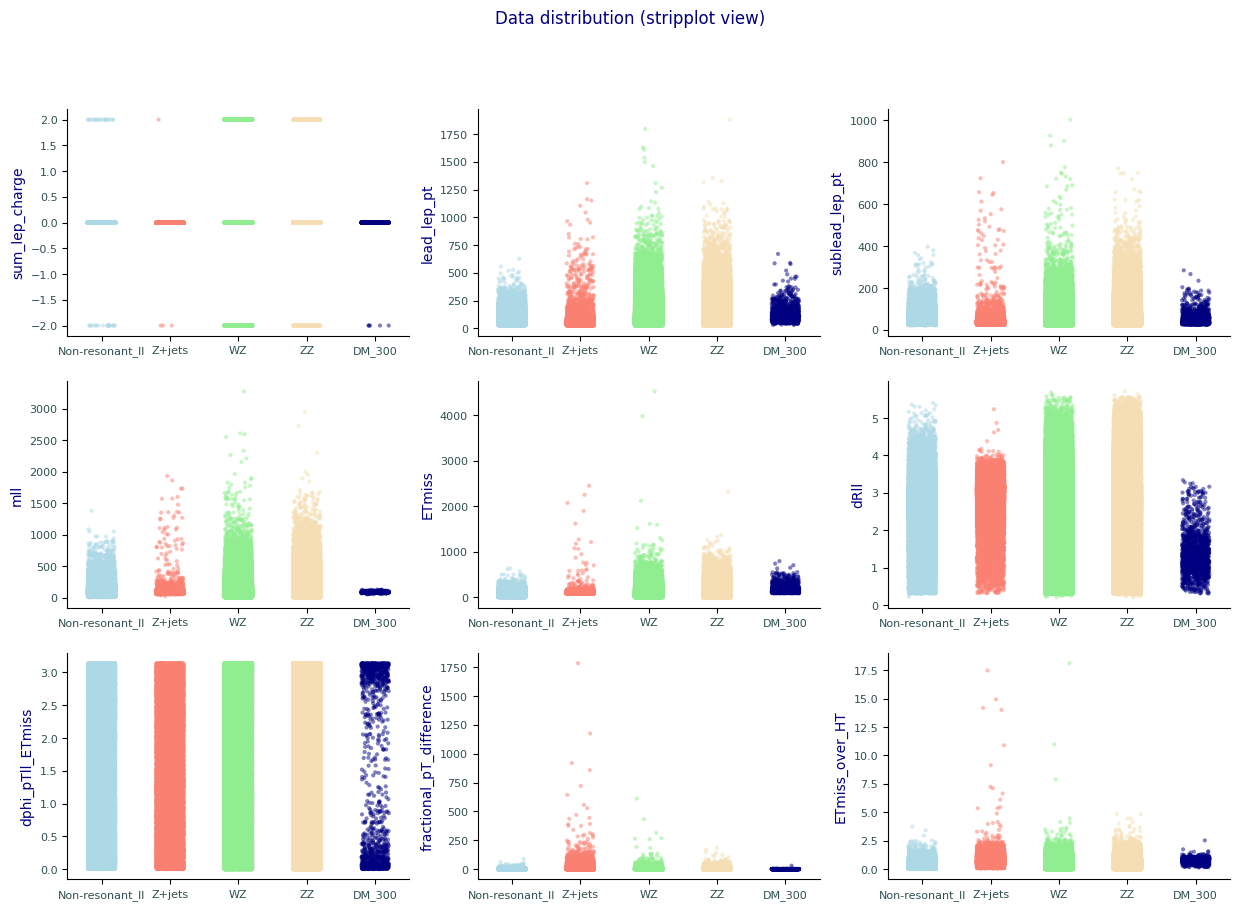

In [ ]:
#@title <font color="coral">*Display*</font>  data distribution accross events (stripplot view)

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle('Data distribution (stripplot view)', color='navy', fontsize=12)
feats = Feats.to_list()
feats.remove('N_bjets')
for i in range(3):
    for j in range(3):
        sns.stripplot(ax=axes[i][j], data=df_2022, x='Event', y=feats[3*i+j], alpha=0.5, jitter=0.2, hue='Event', size=3,
              palette=Palette, legend=False);
        axes[i][j].set_xlabel('', color='navy', fontsize=1)
        axes[i][j].set_ylabel(feats[3*i+j], color='navy', fontsize=10)
        axes[i][j].tick_params(labelsize=8, labelcolor='darkslategray')
sns.despine();

In [ ]:
df_2022[df_2022.Event=='DM_300'].describe().round(3)

,totalWeight,sum_lep_charge,lead_lep_pt,sublead_lep_pt,mll,ETmiss,dRll,dphi_pTll_ETmiss,fractional_pT_difference,ETmiss_over_HT,N_bjets
count,1263.000,1263.000,1263.000,1263.000,1263.000,1263.000,1263.000,1263.000,1263.000,1263.000,1263.0
mean,0.062,-0.008,127.755,55.908,90.318,180.864,1.395,1.529,0.160,0.773,0.0
std,0.021,0.126,73.445,31.538,6.912,95.413,0.580,1.348,0.896,0.213,0.0
min,0.000,-2.000,31.022,23.310,51.142,90.241,0.305,0.000,0.000,0.128,0.0
25%,0.045,0.000,81.729,34.226,88.006,114.256,0.992,0.123,0.017,0.647,0.0
50%,0.071,0.000,107.211,46.981,90.316,151.098,1.309,1.217,0.047,0.801,0.0
75%,0.077,0.000,149.834,66.540,92.487,209.376,1.699,3.011,0.124,0.919,0.0
max,0.204,0.000,670.323,283.768,129.956,793.692,3.334,3.142,29.549,2.523,0.0


In [ ]:
#df_2022[df_2022['totalWeight']<0]

In [4]:
# drop N_bjets
df_app = df_2022.drop('N_bjets', axis=1)

# cut by ETmiss
df_app = df_app[df_app['ETmiss']>90.24]

# cut by sum lepton charge
# df_app = df_app[(df_app['sum_lep_charge']>-1) | (df_app['sum_lep_charge']<1)]
# df_app = df_app.drop('sum_lep_charge', axis=1)
# cut by leptons pT
#df_app = df_app[(df_app['lead_lep_pt']<=671) & (df_app['sublead_lep_pt']<=284)]
# cut by mll
#df_app = df_app[(df_app['mll']<=130) & (df_app['mll']>=51)]
# cut by ETmiss
#df_app = df_app[(df_app['ETmiss']>80.3)] #& (df_app['ETmiss']<526)
#df_app = df_app[(df_app['ETmiss']>90.24)]
# cut by dRll
#df_app = df_app[(df_app['dRll']<2.5)]
# cut by dphi
#df_app = df_app[(df_app['dphi_pTll_ETmiss']>=2.5) | (df_app['dphi_pTll_ETmiss']<0.9)]
# cut by fractional pT difference
#df_app = df_app[df_app['fractional_pT_difference']<=0.6]
# cut by ETmiss over HT
#df_app = df_app[(df_app['ETmiss_over_HT']<=1.2) & (df_app['ETmiss_over_HT']>=0.28)]

print(f'Size of selection: {len(df_app)} - {round(len(df_app)*100/len(df_2022),1)} % of original')
print(round(100*len(df_app[df_app.Event=='DM_300'])/len(df_2022[df_2022.Event=='DM_300']),1),'% of signal is kept')

Size of selection: 276265 - 22.4 % of original
100.0 % of signal is kept


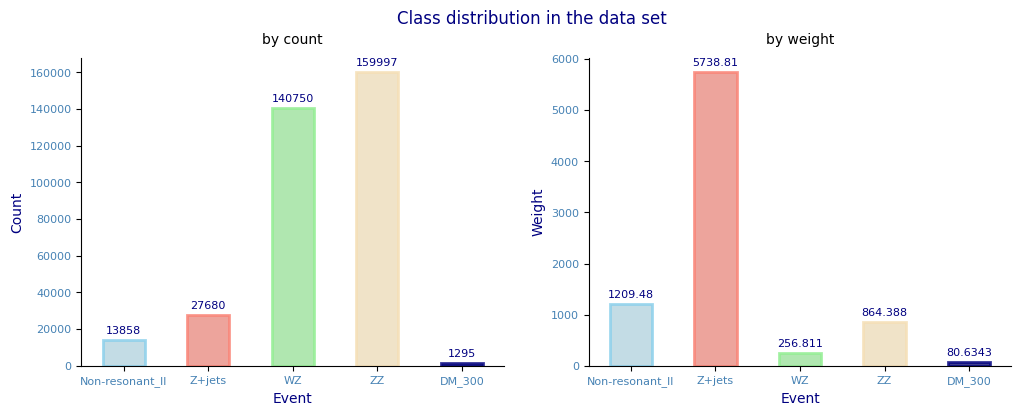

In [ ]:
#@title <font color="royalblue">*Show*</font> event distribution in the selection

# plot class distribution in the training set
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Class distribution in the data set', color='navy', y=1)

sns.countplot(ax=axes[0], data=df_app, x='Event',
              width=0.5, alpha=0.8, lw=2, palette=Palette,
              ec=['skyblue', 'salmon', 'lightgreen', 'wheat', 'navy']
              )
axes[0].set_title('by count', fontsize=10, y=1.02)
axes[0].bar_label(axes[0].containers[0], fontsize=8, color='navy', padding=3)

sns.barplot(ax=axes[1], data=df_app, x='Event', y='totalWeight', estimator='sum',
            errorbar=None, width=0.5, alpha=0.8, lw=2, palette=Palette,
            ec=['skyblue', 'salmon', 'lightgreen', 'wheat', 'navy']
            )
axes[1].set_title('by weight', fontsize=10, y=1.02)
axes[1].bar_label(axes[1].containers[0], fontsize=8, color='navy', padding=3)

axes[0].set_xlabel('Event', color='navy', fontsize=10)
axes[0].set_ylabel('Count', color='navy', fontsize=10)
axes[0].tick_params(labelsize=8, labelcolor='steelblue')

axes[1].set_xlabel('Event', color='navy', fontsize=10)
axes[1].set_ylabel('Weight', color='navy', fontsize=10)
axes[1].tick_params(labelsize=8, labelcolor='steelblue')

sns.despine();

interactive(children=(Dropdown(description='Parameter:', index=4, options=('sum_lep_charge', 'lead_lep_pt', 's…

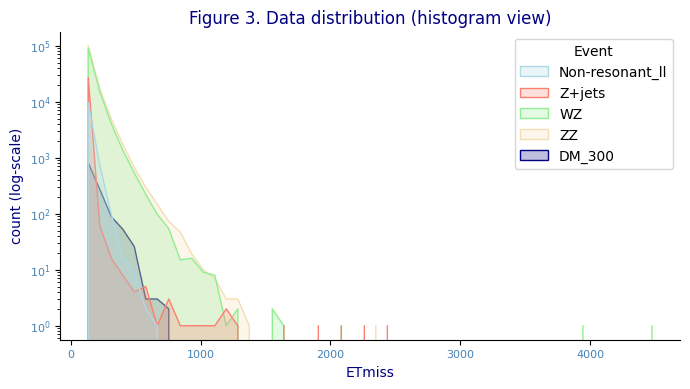

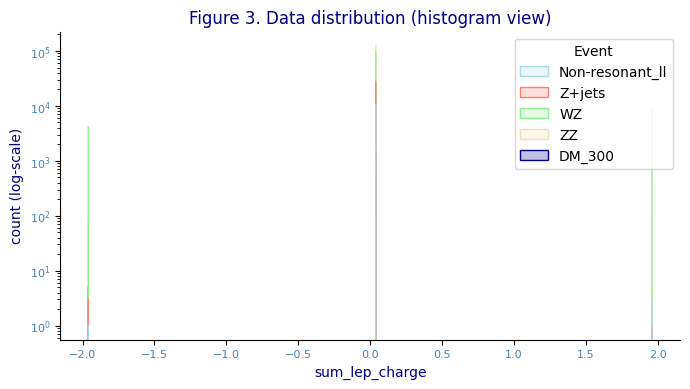

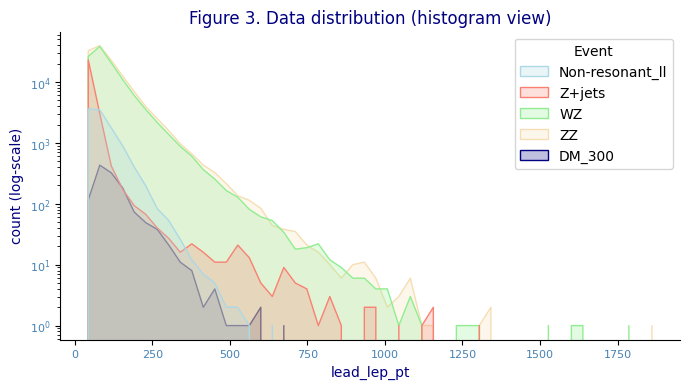

In [87]:
#@title <font color="coral">*Display*</font>  data distribution accross events (histogram view)

parameter_hist = widgets.Dropdown(options=Feats, value='ETmiss', description='Parameter:')

def hist_distribution(data, number, feature):
    plt.figure(figsize=(8,4))
    sns.histplot(data, x=feature, hue="Event", element="poly", bins=50, log_scale=[False,True],
                 palette=Palette)
    plt.title(f"Figure {number}. Data distribution (histogram view)", color='navy', fontsize=12)
    plt.xticks(fontsize=8, color='steelblue', rotation=0)
    plt.yticks(fontsize=8, color='steelblue')
    plt.xlabel(feature, color='navy', fontsize=10)
    plt.ylabel("count (log-scale)", color='navy', fontsize=10)
    sns.despine();

widgets.interact(hist_distribution, data = widgets.fixed(df_app), number = widgets.fixed(3), feature = parameter_hist);

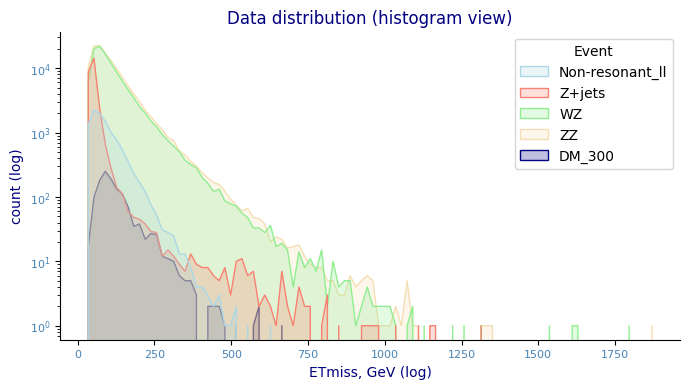

In [90]:
plt.figure(figsize=(8,4))
sns.histplot(df_app, x='lead_lep_pt', hue="Event", element="poly", bins=100, log_scale=[False,True],
              palette=Palette)
plt.title(f"Data distribution (histogram view)", color='navy', fontsize=12)
plt.xticks(fontsize=8, color='steelblue', rotation=0)
plt.yticks(fontsize=8, color='steelblue')
plt.xlabel('ETmiss, GeV (log)', color='navy', fontsize=10)
plt.ylabel("count (log)", color='navy', fontsize=10)
sns.despine();

interactive(children=(Dropdown(description='Parameter:', index=4, options=('sum_lep_charge', 'lead_lep_pt', 's…

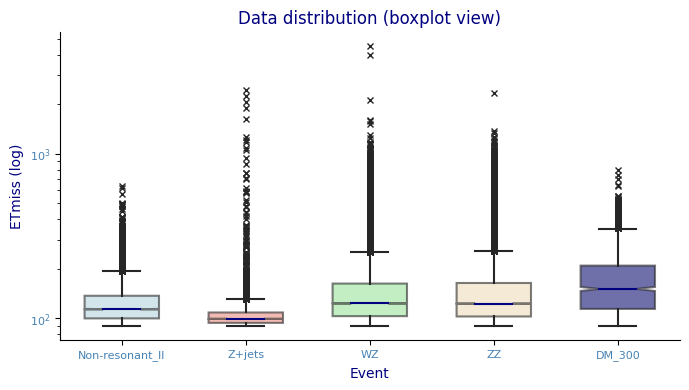

In [77]:
#@title <font color="coral">*Display*</font>  data distribution accross events (boxplot view)

parameter_box = widgets.Dropdown(options=Feats, value='ETmiss', description='Parameter:')

def box_distribution(data, number, feature):
    plt.figure(figsize=(8,4))
    sns.boxplot(data, y=feature, x='Event', orient='v', width=0.6, notch=True,
                boxprops=dict(alpha=.6), flierprops={"marker": "x"}, medianprops={"color": "navy"},
                palette=Palette)
    plt.title(f"Data distribution (boxplot view)", color='navy', fontsize=12)
    plt.xticks(fontsize=8, color='steelblue', rotation=0)
    plt.yticks(fontsize=8, color='steelblue')
    plt.xlabel("Event", color='navy', fontsize=10)
    plt.ylabel(f'{feature} (log)', color='navy', fontsize=10)
    plt.yscale('log')
    sns.despine();

widgets.interact(box_distribution, data = widgets.fixed(df_app), number = widgets.fixed(4), feature = parameter_box);

## **4. <font color=navy> MLP modelling (selection from the 2022 data set)**

### *4.1 <font color=navy> Data pre-processing*

In [5]:
#@title <font color="royalblue">**Count**</font> balanced training set; testing set - keeps ***selection*** proportions

def balanced_count_split(df, random_seed, fr=0.7):
    df_train = pd.DataFrame(columns=df.keys())  # frame the training subset
    events = df['Event'].unique()               # list all events
    train_DM = df[df['Event']=='DM_300'].sample(frac=fr, random_state=random_seed)  # training part of DM subset
    train_DM_size = len(train_DM)  # size of training DM subset
    full_DM_size = len(df[df['Event']=='DM_300'])  # full size of training DM subset
    full_size = len(df)
    full_BKG_size = full_size - full_DM_size
    k=1
    for event in events:
        if event!=events[-1]:
            df_event = df[df['Event']==event]            # form the current Event subset

            full_Event_size = len(df[df['Event']==event])
            R = full_Event_size/full_BKG_size
            N = train_DM_size*R*4*k

            train_part = df_event.sample(n=int(N), random_state=random_seed)  # take a random sample
            df_train = pd.concat([df_train,train_part])   # append the training subset
    df_train = pd.concat([df_train,train_DM])

    # now split the rest of data into testing and background (with no DM) subsets
    df_rest = df.drop(df_train.index)              # rest = dataset - training subset
    df_test = pd.DataFrame(columns=df.keys())      # frame the 'testing' subset
    test_DM = df_rest[df_rest['Event']=='DM_300']  # extract all DM data to include in the testing subset
    test_DM_size = full_DM_size-train_DM_size
    for event in events:
        if event!=events[-1]:
            df_event = df_rest[df_rest['Event']==event]    # form the current Event subset
            full_Event_size = len(df[df['Event']==event])
            N = full_Event_size*(1-fr)
            test_part = df_event.sample(n=int(N), random_state=random_seed)  # take random sample
            df_test = pd.concat([df_test,test_part])      # append the background subset
    df_test = pd.concat([df_test,test_DM])

    return df_train, df_test

# split into train and test sets
df_train, df_test = balanced_count_split(df_app, random_seed=seed)

# # plot class distribution in the training set
# fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
# fig.suptitle('Class distribution', color='navy', y=1)

# sns.countplot(ax=axes[0], data=df_train, x='Event',
#               width=0.5, alpha=0.8, lw=2, palette=Palette,
#               ec=['skyblue', 'salmon', 'lightgreen', 'wheat', 'navy']
#               )
# axes[0].set_title('train set', fontsize=10, y=1.02)
# axes[0].bar_label(axes[0].containers[0], fontsize=8, color='navy', padding=3)

# sns.countplot(ax=axes[1], data=df_test, x='Event',
#               width=0.5, alpha=0.8, lw=2, palette=Palette,
#               ec=['skyblue', 'salmon', 'lightgreen', 'wheat', 'navy']
#               )
# axes[1].set_title('test set', fontsize=10, y=1.02)
# axes[1].bar_label(axes[1].containers[0], fontsize=8, color='navy', padding=3)

# axes[0].set_xlabel('Event', color='navy', fontsize=10)
# axes[0].set_ylabel('Count', color='navy', fontsize=10)
# axes[0].tick_params(labelsize=8, labelcolor='steelblue')

# axes[1].set_xlabel('Event', color='navy', fontsize=10)
# axes[1].set_ylabel('Count', color='navy', fontsize=10)
# axes[1].tick_params(labelsize=8, labelcolor='steelblue')

sns.despine();

# split distributions
checktable={}
for event in df_app.Event.unique():
    E={}
    E['Full size'] = a = len(df_app[df_app['Event']==event])
    E['full weight'] = c= sum(df_app[df_app['Event']==event]['totalWeight'])
    E['Train size'] = b = len(df_train[df_train['Event']==event])
    #E['size ratio'] = a/b
    E['train weight'] = d = sum(df_train[df_train['Event']==event]['totalWeight'])
    #E['weight ratio'] = c/d
    E['Test size'] = len(df_test[df_test['Event']==event])
    E['test weight'] = sum(df_test[df_test['Event']==event]['totalWeight'])
    checktable[event]=E

print('Train size: ',len(df_train),'\nTest size: ',len(df_test),'\nFull size:',len(df_app))
pd.DataFrame(checktable).round(1)

Train size:  4419 
Test size:  82877 
Full size: 276265


,Non-resonant_ll,Z+jets,WZ,ZZ,DM_300
Full size,10519.0,27065.0,111883.0,125535.0,1263.0
full weight,917.3,5611.1,195.0,636.4,78.6
Train size,135.0,348.0,1438.0,1614.0,884.0
train weight,12.2,70.6,2.3,7.8,55.8
Test size,3155.0,8119.0,33564.0,37660.0,379.0
test weight,275.2,1669.3,58.3,190.3,22.8


<Figure size 432x288 with 0 Axes>

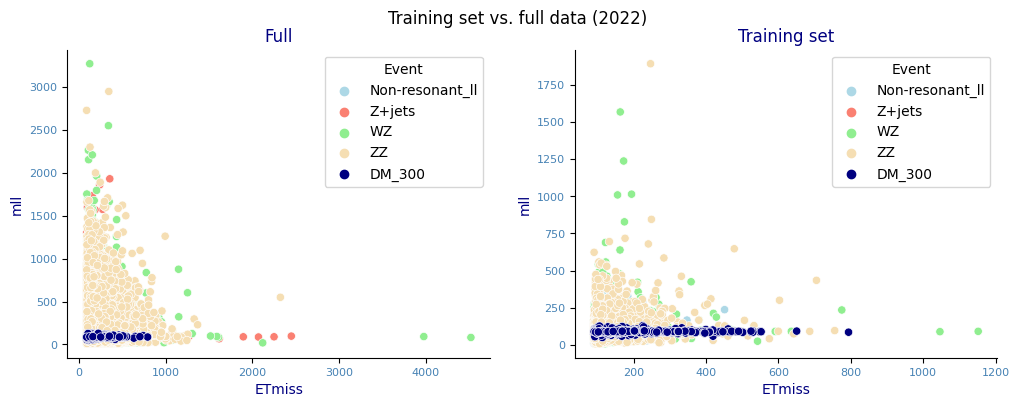

In [ ]:
#@title <font color="royalblue">*Compare*</font> the full data with the training set

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Training set vs. full data (2022)')

sns.scatterplot(ax=axes[0], x=df_app['ETmiss'], y=df_app['mll'], hue=df_app.Event,
                lw=1, ec='white', palette=Palette)
axes[0].set_title('Full', color='navy', fontsize=12)

sns.scatterplot(ax=axes[1], x=df_train['ETmiss'], y=df_train['mll'], hue=df_train.Event,
                lw=1, ec='white', palette=Palette)
axes[1].set_title('Training set', color='navy', fontsize=12)

axes[0].set_xlabel('ETmiss', color='navy', fontsize=10)
axes[0].set_ylabel('mll', color='navy', fontsize=10)
axes[0].tick_params(labelsize=8, labelcolor='steelblue')

axes[1].set_xlabel('ETmiss', color='navy', fontsize=10)
axes[1].set_ylabel('mll', color='navy', fontsize=10)
axes[1].tick_params(labelsize=8, labelcolor='steelblue')

sns.despine();

In [71]:
print('Total number of events:', len(df_app))
print('Number of events mll>500:', len(df_app[df_app['mll']>500]))
print('Number of events ETmiss>500:', len(df_app[df_app['ETmiss']>500]))

Total number of events: 276265
Number of events mll>500: 2599
Number of events ETmiss>500: 1401


In [6]:
# split the train/test datasets into the feature, labels and weights subsets
X_train = df_train.drop(['Event','totalWeight'], axis=1).values
W_train = df_train['totalWeight'].values.astype('float64')
Y_train = df_train['Event'].values
Y_train = np.array([1 if e=='DM_300' else 0 for e in Y_train])  # binarise classes (1-Signal, 0-Background)

X_test = df_test.drop(['Event','totalWeight'], axis=1).values
W_test = df_test['totalWeight'].values.astype('float64')
Y_test = df_test['Event'].values
Y_test = np.array([1 if e=='DM_300' else 0 for e in Y_test])  # binarise classes (1-Signal, 0-Background)

# Initialise the Scaler
scaler = StandardScaler()

# Scale the sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# extract test set ids
test_ids = df_test.reset_index()
test_ids = test_ids['index']

In [92]:
### only for App purposes (don't click for ML)
# reduce size
df_test00 = df_test.astype({'totalWeight':'float16'})
df_test00 = df_test00.round({'lead_lep_pt': 1, 'sublead_lep_pt': 1, 'mll': 1, 'ETmiss': 1,'dRll': 2, 'dphi_pTll_ETmiss': 3,'fractional_pT_difference': 3, 'ETmiss_over_HT': 3,})
# # add non-negative duplicate of Weights (for bubble chart)
# totalWeight = df_test00['totalWeight'].to_list()
# follyWeight = [w*1000 if w>0 else 0 for w in totalWeight]
# df_test00['follyWeight'] = follyWeight
# df_test00 = df_test00.round({'follyWeight': 0})

# save Test data for visualising in Scatter plot in WebApp
df_test00.to_csv('/content/drive/My Drive/Diss modelling/df_test.csv', index=True, index_label='index')

In [9]:
# form a shortlist df from the testing data to use with MLP visualisation
def shortlist(df, x_scaled, random_seed, N=3):
    df_shortlist = pd.DataFrame(columns=df.keys())  # frame the subset
    events = df['Event'].unique()                   # list all events
    for event in events:
        df_event = df[df['Event']==event]       # extract the current class data
        short_part = df_event.sample(n=N, random_state=random_seed)  # take a random sample of N size
        df_shortlist = pd.concat([df_shortlist,short_part])   # append the training subset

    df_shortlist_scaled = pd.DataFrame(x_scaled, index=df_test.index)
    df_shortlist_scaled = df_shortlist_scaled.loc[df_shortlist.index]

    return df_shortlist, df_shortlist_scaled

# split into train and test sets
df_shortlist, df_shortlist_scaled = shortlist(df_test, X_test_scaled, random_seed=0)

# save Shortlist and Scaled Shortlist for App access
df_shortlist.to_csv('/content/drive/My Drive/Diss modelling/df_shortlist.csv', index=True, index_label='index')
df_shortlist_scaled.to_csv('/content/drive/My Drive/Diss modelling/df_shortlist_scaled.csv', index=True, index_label='index')

#### *6.1.0 <font color=chocolate>worse performing options*

Train size:  5049 
Test size:  55250 
Full size: 276265


,Non-resonant_ll,Z+jets,WZ,ZZ,DM_300
Full size,10519.0,27065.0,111883.0,125535.0,1263.0
full weight,917.3,5611.1,195.0,636.4,78.6
Train size,503.0,3080.0,107.0,349.0,1010.0
train weight,45.0,636.6,0.2,1.8,63.4
Test size,2103.0,5412.0,22376.0,25106.0,253.0
test weight,181.6,1124.7,38.9,126.4,15.1


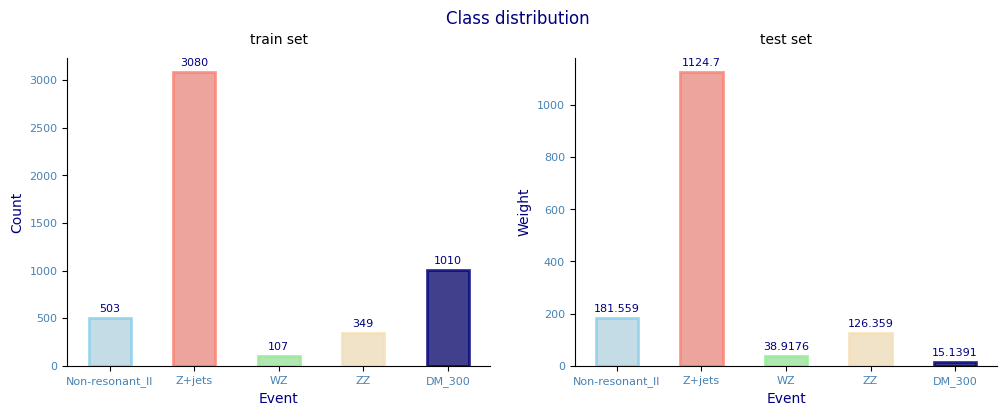

In [ ]:
#@title <font color="firebrick">**Weight**</font> balanced training set ; testing set - keeps ***selection*** proportions

def hybrid_split(df, random_seed, fr=0.8):
    df_train = pd.DataFrame(columns=df.keys())  # frame the training subset
    events = df['Event'].unique()               # list all events
    train_DM = df[df['Event']=='DM_300'].sample(frac=fr, random_state=random_seed)  # training part of DM subset
    train_DM_size = len(train_DM)  # size of training DM subset
    full_DM_weight = sum(df[df['Event']=='DM_300']['totalWeight'])  # total weight of DM subset
    full_weight = sum(df['totalWeight'])  # total weight of selection
    full_BKG_weight = full_weight - full_DM_weight

    for event in events:
        if event!=events[-1]:
            df_event = df[df['Event']==event]            # form the current Event subset

            full_Event_weight = sum(df[df['Event']==event]['totalWeight'])
            R = full_Event_weight/full_BKG_weight
            N = train_DM_size*R*4

            train_part = df_event.sample(n=int(N), random_state=random_seed)  # take a random sample
            df_train = pd.concat([df_train,train_part])   # append the training subset
    df_train = pd.concat([df_train,train_DM])

    # now split the rest of data into testing and background (with no DM) subsets
    df_rest = df.drop(df_train.index)              # rest = dataset - training subset
    df_test = pd.DataFrame(columns=df.keys())      # frame the 'testing' subset
    test_DM = df_rest[df_rest['Event']=='DM_300']  # extract all DM data to include in the testing subset

    for event in events:
        if event!=events[-1]:
            df_event = df_rest[df_rest['Event']==event]  # form the current Event subset
            full_Event_size = len(df[df['Event']==event])
            N = full_Event_size*(1-fr)
            test_part = df_event.sample(n=int(N), random_state=random_seed)  # take random sample
            df_test = pd.concat([df_test,test_part])      # append the testing subset
    df_test = pd.concat([df_test,test_DM])

    return df_train, df_test

# split into train and test sets
df_train, df_test = hybrid_split(df_app, random_seed=seed)

# plot class distribution in the training set
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Class distribution', color='navy', y=1)

sns.countplot(ax=axes[0], data=df_train, x='Event',
              alpha=0.8, palette=Palette, lw=2, width=0.5,
              ec=['skyblue', 'salmon', 'lightgreen', 'wheat', 'navy']
              )
axes[0].set_title('train set', fontsize=10, y=1.02)
axes[0].bar_label(axes[0].containers[0], fontsize=8, color='navy', padding=3)

sns.barplot(ax=axes[1], data=df_test, x='Event', y='totalWeight', estimator='sum',
            errorbar=None, alpha=0.8, palette=Palette, lw=2, width=0.5,
            ec=['skyblue', 'salmon', 'lightgreen', 'wheat', 'navy']
            )
axes[1].set_title('test set', fontsize=10, y=1.02)
axes[1].bar_label(axes[1].containers[0], fontsize=8, color='navy', padding=3)

axes[0].set_xlabel('Event', color='navy', fontsize=10)
axes[0].set_ylabel('Count', color='navy', fontsize=10)
axes[0].tick_params(labelsize=8, labelcolor='steelblue')

axes[1].set_xlabel('Event', color='navy', fontsize=10)
axes[1].set_ylabel('Weight', color='navy', fontsize=10)
axes[1].tick_params(labelsize=8, labelcolor='steelblue')

sns.despine();

# split distributions
checktable={}
for event in df_app.Event.unique():
    E={}
    E['Full size'] = a = len(df_app[df_app['Event']==event])
    E['full weight'] = c= sum(df_app[df_app['Event']==event]['totalWeight'])
    E['Train size'] = b = len(df_train[df_train['Event']==event])
    #E['size ratio'] = a/b
    E['train weight'] = d = sum(df_train[df_train['Event']==event]['totalWeight'])
    #E['weight ratio'] = c/d
    E['Test size'] = len(df_test[df_test['Event']==event])
    E['test weight'] = sum(df_test[df_test['Event']==event]['totalWeight'])
    checktable[event]=E

print('Train size: ',len(df_train),'\nTest size: ',len(df_test),'\nFull size:',len(df_app))
pd.DataFrame(checktable).round(1)

Train size:  4420 
Test size:  82877 
Full size: 276265


,Non-resonant_ll,Z+jets,WZ,ZZ,DM_300
Full size,10519.0,27065.0,111883.0,125535.0,1263.0
full weight,917.3,5611.1,195.0,636.4,78.6
Train size,884.0,884.0,884.0,884.0,884.0
train weight,77.2,180.5,1.4,4.2,55.8
Test size,3155.0,8119.0,33564.0,37660.0,379.0
test weight,275.7,1696.3,58.7,188.0,22.8


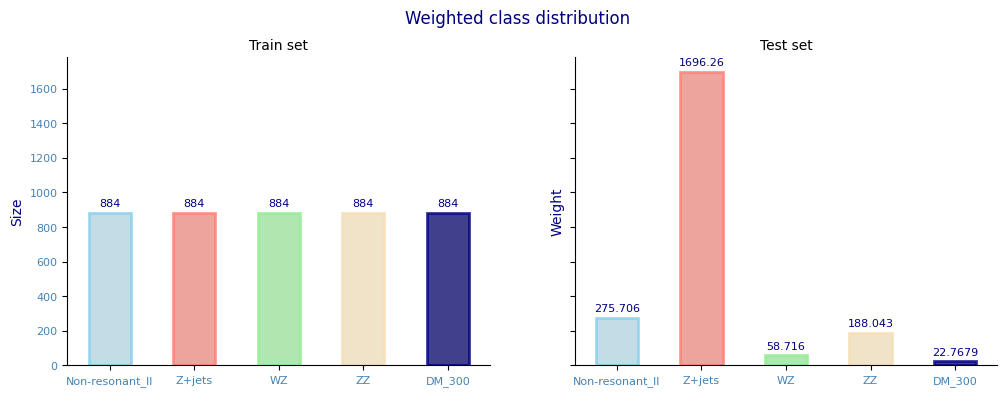

In [ ]:
#@title <font color="royalblue">**Equal**</font> training set ; testing set - keeps ***selection*** proportions
def equal_weight_split(df, random_seed, fr=0.7):
    df_train = pd.DataFrame(columns=df.keys())  # frame the training subset
    events = df['Event'].unique()               # list all events
    train_DM = df[df['Event']=='DM_300'].sample(frac=fr, random_state=random_seed)  # training part of DM subset
    train_DM_size = len(train_DM)  #

    for event in events:
        if event!=events[-1]:
            df_event = df[df['Event']==event]            # form the current Event subset
            train_part = df_event.sample(n=train_DM_size, random_state=random_seed)  # take a random sample
            df_train = pd.concat([df_train,train_part])   # append the training subset
    df_train = pd.concat([df_train,train_DM])

    # now split the rest of data into testing and background (with no DM) subsets
    df_rest = df.drop(df_train.index)              # rest = dataset - training subset
    df_test = pd.DataFrame(columns=df.keys())      # frame the 'testing' subset
    test_DM = df_rest[df_rest['Event']=='DM_300']  # extract all DM data to include in the testing subset

    for event in events:
        if event!=events[-1]:
            df_event = df_rest[df_rest['Event']==event]  # form the current Event subset
            full_Event_size = len(df[df['Event']==event])
            N = full_Event_size*(1-fr)
            test_part = df_event.sample(n=int(N), random_state=random_seed)  # take random sample
            df_test = pd.concat([df_test,test_part])      # append the testing subset
    df_test = pd.concat([df_test,test_DM])

    return df_train, df_test

# split into training, testing subsets
df_train, df_test = equal_weight_split(df_app, random_seed=seed)


# plot weighted class distribution in resulting subsets
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.suptitle('Weighted class distribution', color='navy', y=1)

sns.countplot(ax=axes[0], data=df_train, x='Event',
              alpha=0.8, palette=Palette, lw=2, width=0.5,
              ec=['skyblue', 'salmon', 'lightgreen', 'wheat', 'navy']
              )
axes[0].set_title('Train set', fontsize=10, y=1)
axes[0].bar_label(axes[0].containers[0], fontsize=8, color='navy', padding=3)

sns.barplot(ax=axes[1], data=df_test, x='Event', y='totalWeight', estimator='sum',
            errorbar=None, width=0.5, alpha=0.8, lw=2, palette=Palette,
            ec=['skyblue', 'salmon', 'lightgreen', 'wheat', 'navy']
            )
axes[1].set_title('Test set', fontsize=10, y=1)
axes[1].bar_label(axes[1].containers[0], fontsize=8, color='navy', padding=3)

axes[0].set_xlabel('', color='navy', fontsize=1)
axes[0].set_ylabel('Size', color='navy', fontsize=10)
axes[0].tick_params(labelsize=8, labelcolor='steelblue')

axes[1].set_xlabel('', color='navy', fontsize=1)
axes[1].set_ylabel('Weight', color='navy', fontsize=10)
axes[1].tick_params(labelsize=8, labelcolor='steelblue')

sns.despine();

# distribution table
checktable={}
for event in df_app.Event.unique():
    E={}
    E['Full size'] = a = len(df_app[df_app['Event']==event])
    E['full weight'] = c= sum(df_app[df_app['Event']==event]['totalWeight'])
    E['Train size'] = b = len(df_train[df_train['Event']==event])
    #E['size ratio'] = a/b
    E['train weight'] = d = sum(df_train[df_train['Event']==event]['totalWeight'])
    #E['weight ratio'] = c/d
    E['Test size'] = len(df_test[df_test['Event']==event])
    E['test weight'] = sum(df_test[df_test['Event']==event]['totalWeight'])
    checktable[event]=E

print('Train size: ',len(df_train),'\nTest size: ',len(df_test),'\nFull size:',len(df_app))
pd.DataFrame(checktable).round(1)

### *4.2 <font color=navy> MLP modelling*

#### *4.2.0 <font color=darkcoral> Model tuning </font> (not included in Diss)*

In [ ]:
#@title **Hyperparameter** <font color="royalblue">tuning</font>
Designs=[(8, ),(8, 6),(6, 8, 6),(8, 8, 4),(10, 10, 10)]

tuning_relu={}
tuning_log={}

# run  the loop to store results of different MLP configuratrions
for design in Designs:
    relu={}
    log={}
    for al in [0.0001, 0.001, 0.01, 0.1, 0.3]:
          # logistic
        MLP = MLPClassifier(hidden_layer_sizes = design, random_state = seed, shuffle=True,
                            max_iter = 1000, alpha=al, activation='logistic',
                            )
        MLP.fit(X_train_scaled, Y_train)
        pred = MLP.predict(X_test_scaled)
        tn, fp, fn, tp = confusion_matrix(Y_test, pred, sample_weight=W_test).ravel()
        S = tp/(fp**0.5)
        log[al]=round(S,2)
        #log[al]=round(f1_score(Y_test, pred, sample_weight=W_test),4)*100

          # relu
        MLP = MLPClassifier(hidden_layer_sizes = design, random_state = seed, shuffle=True,
                            max_iter = 1000, alpha=al, activation='relu',
                            )
        MLP.fit(X_train_scaled, Y_train)
        pred = MLP.predict(X_test_scaled)
        tn, fp, fn, tp = confusion_matrix(Y_test, pred, sample_weight=W_test).ravel()
        S = tp/(fp**0.5)
        relu[al]=round(S,2)
        #relu[al]=round(f1_score(Y_test, pred, sample_weight=W_test),4)*100
    tuning_relu[f'{design}']=relu
    tuning_log[f'{design}']=log

metrics_relu = pd.DataFrame(tuning_relu)
metrics_log = pd.DataFrame(tuning_log)

In [ ]:
# search best tuning with the full train set
clf = MLPClassifier(random_state=seed, shuffle=True, max_iter = 1000)
param_grid = {'hidden_layer_sizes': [(8, ),(8, 6),(6, 8, 6),(8, 8, 4),(10, 10, 10)],
              'alpha': [0.0001, 0.001, 0.01, 0.1, 0.3],
              }

search = GridSearchCV(clf, param_grid, scoring='f1').fit(X_train_scaled, Y_train)

# print('Best F1-score =',round(search.best_score_*100,2),'%')
# print('\n Optimal parameters: \n')
# search.best_params_

In [ ]:
search.cv_results_['params']

In [ ]:
search.cv_results_['rank_test_score']

In [ ]:
Designs = [(8, ),(8, 6),(6, 8, 6),(8, 8, 4),(10, 10, 10)]
Alphas = [0.0001, 0.001, 0.01, 0.1, 0.3]
Grid = pd.DataFrame()
search.best_score_
search.best_params_
ranks = search.cv_results_['rank_test_score']
for i,al in enumerate(Alphas):
    cell = {}
    for j,d in enumerate(Designs):
        cell[f'{d}']=ranks[5*i+j]
    Grid[al]=cell
Grid

,0.0001,0.0010,0.0100,0.1000,0.3000
"(8,)",22,18,17,12,23
"(8, 6)",16,10,13,15,20
"(6, 8, 6)",25,11,8,24,7
"(8, 8, 4)",14,19,6,21,9
"(10, 10, 10)",1,2,4,5,3


In [ ]:
Designs = [(8, ),(8, 6),(6, 8, 6),(8, 8, 4),(10, 10, 10)]
Alphas = [0.01, 0.05, 0.1, 0.3, 0.5]
Grid = pd.DataFrame()
search.best_score_
search.best_params_
ranks = search.cv_results_['rank_test_score']
for i,al in enumerate(Alphas):
    cell = {}
    for j,d in enumerate(Designs):
        cell[f'{d}']=ranks[5*i+j]
    Grid[al]=cell
Grid

,0.01,0.05,0.10,0.30,0.50
"(8,)",17,15,10,22,25
"(8, 6)",12,16,14,20,13
"(6, 8, 6)",8,18,24,7,23
"(8, 8, 4)",4,19,21,9,11
"(10, 10, 10)",2,5,3,1,6


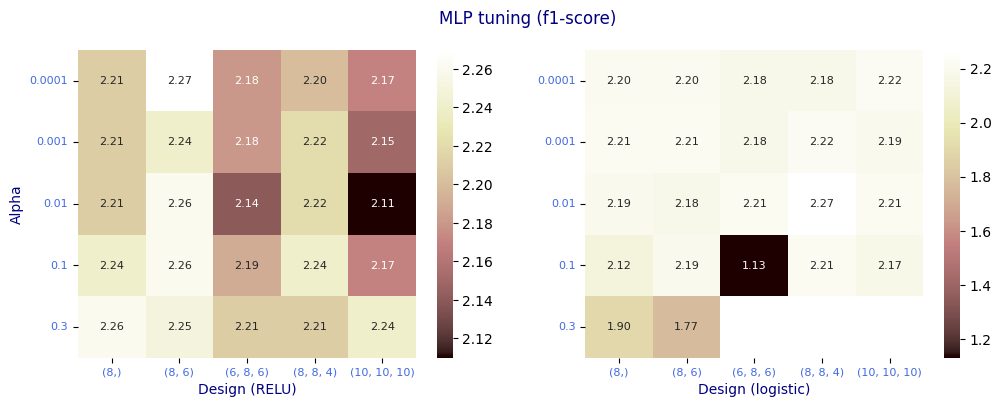

In [ ]:
#@title **Plot** <font color="chocolate">heatmaps</font> of parameters' tuning
fig, axes = plt.subplots(1,2, constrained_layout=False, figsize=(12, 4))
sns.heatmap(metrics_relu, cmap='pink', annot=True, annot_kws={'size': 8}, fmt='.2f',ax=axes[0]).set_xlabel("Design (RELU)",color='navy',fontsize=10)
sns.heatmap(metrics_log, cmap='pink', annot=True, annot_kws={'size': 8}, fmt='.2f',ax=axes[1]).set_xlabel("Design (logistic)",color='navy',fontsize=10)
axes[0].set_ylabel("Alpha",color='navy',fontsize=10)
axes[0].tick_params(labelcolor='royalblue',labelsize=8, rotation=0)
axes[1].tick_params(labelcolor='royalblue',labelsize=8, rotation=0)
plt.suptitle("MLP tuning (f1-score)",color='navy',fontsize=12);

#### *4.2.1 <font color=darkgreen> Modelling </font>*

In [ ]:
# create list of MLP designs (combinations of hidden layers) from (1,) to (10,10,10)
Designs = []
for a in range(2,11,2):
    Designs.append((a,))

for a in range(2,11,2):
    for b in range(2,11,2):
        Designs.append((a,b))

for a in range(2,11,2):
    for b in range(2,11,2):
        for c in range(2,11,2):
            Designs.append((a,b,c))

len(Designs)

155

In [ ]:
# create list of MLP designs (combinations of hidden layers) from (20, 20, 20) to (100, 100, 100)
Designs3 = []
for a in range(20,120,20):
    for b in range(20,120,20):
        for c in range(20,120,20):
            Designs3.append((a,b,c))
len(Designs3)

125

In [7]:
Designs=[(6, 8, 4, 8, 6), (20, 30, 40, 30, 20),
         (6, 8, 6, 8, 8, 4, 10, 8), (26, 38, 56, 78, 28, 14, 100, 18),
          (10, 10, 10, 10, 10, 10, 10, 10, 10, 10), (40, 50, 60, 40, 70, 90, 100, 10, 30, 50)]

In [8]:
# Designs=[(8, ),(8, 6),(6, 8, 6),(8, 8, 4),(10, 10, 10)]
# prepare dataframes for storing resulting probabilities and metrics
Probs = pd.DataFrame(Y_test, columns=['Event'], index=test_ids)
Probs['Weight'] = W_test
df_metrics = pd.DataFrame(index=['Accuracy','Precision','Recall','f1-score','S'])

# run  the loop to store results of different MLP configuratrions
for design in Designs:
    MLP = MLPClassifier(hidden_layer_sizes = design,
                        random_state = seed,
                        shuffle=True,
                        max_iter = 1000,        # def=200
                        alpha=0.0001, #0.05,             # def=0.0001
                        activation='relu',  # def=’relu’
                        )
    MLP.fit(X_train_scaled, Y_train)
    sig_prob = MLP.predict_proba(X_test_scaled)[:, 1]
    pred = MLP.predict(X_test_scaled)

    Probs[design]=sig_prob.round(2)

    tn, fp, fn, tp = confusion_matrix(Y_test, pred, sample_weight=W_test).ravel()
    S = tp/(fp**0.5)

    df_metrics[design]=np.array([accuracy_score(Y_test, pred, sample_weight=W_test),
                                precision_score(Y_test, pred, sample_weight=W_test),
                                recall_score(Y_test, pred, sample_weight=W_test),
                                f1_score(Y_test, pred, sample_weight=W_test),
                                S/100
                                ]).round(4)*100

df_probs = Probs.astype({'Weight':'float16'})


# save Probs and Metrics from Colab
# df_probs.to_csv('/content/drive/My Drive/Diss modelling/df_probs_2022_m.csv', index=True, index_label='index')
# df_metrics.to_csv('/content/drive/My Drive/Diss modelling/df_metrics_2022_m.csv', index=True, index_label='index')

# # save from Jupyter
df_probs.to_csv('G:/My Drive/Diss modelling/df_probs_2022_m.csv', index=True, index_label='index')
df_metrics.to_csv('G:/My Drive/Diss modelling/df_metrics_2022_m.csv', index=True, index_label='index')

In [10]:
# upload Probs and Metrics from Colab
df_probs = pd.read_csv('/content/drive/My Drive/Diss modelling/df_probs_2022.csv',index_col='index')
df_metrics = pd.read_csv('/content/drive/My Drive/Diss modelling/df_metrics_2022.csv',index_col='index')

# # upload from Jupyter
# df_probs = pd.read_csv('G:/My Drive/Diss modelling/df_probs_2022_w.csv',index_col='index')
# df_metrics = pd.read_csv('G:/My Drive/Diss modelling/df_metrics_2022_w.csv',index_col='index')

### *4.3 <font color=navy> Analysis of MLP performance*

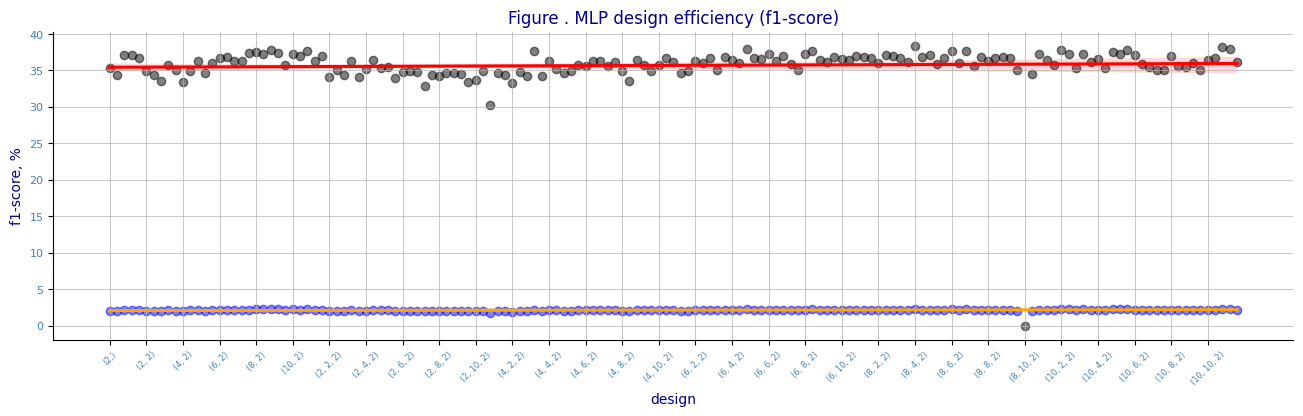

In [13]:
#@title <font color="royalblue">*F1-score*</font> vs. MLP design
plt.figure(figsize=(16,4))
sns.regplot(x = df_metrics.T.reset_index().index, y = df_metrics.T['f1-score'],
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red"});
sns.regplot(x = df_metrics.T.reset_index().index, y = df_metrics.T['S'],
            scatter_kws = {"color": "blue", "alpha": 0.5},
            line_kws = {"color": "orange"});
plt.xlabel('design', color='navy', fontsize=10)
plt.ylabel('f1-score, %', color='navy', fontsize=10)
plt.xticks(ticks = [df_metrics.T.reset_index().index[t] for t in range(0, len(df_metrics.T.reset_index().index), 5)],
           labels = [df_metrics.T.index[t] for t in range(0, len(df_metrics.T.index), 5)],
           color='steelblue',fontsize=6, rotation=45)
plt.yticks(color='steelblue',fontsize=8)
plt.title('Figure . MLP design efficiency (f1-score)',color='navy',fontsize=12)
plt.grid(linewidth=0.5)
sns.despine();

In [16]:
#@title <font color="royalblue">*Find*</font> best performing design
f1max = df_metrics.T['f1-score'].max()
Prmax = df_metrics.T['Precision'].max()
Rmax = df_metrics.T['Recall'].max()
Smax = df_metrics.T['S'].max()
print('Best f1-score: ',f1max)
print('Best precision:',Prmax)
print('Best recall:',Rmax)
print('Best significance:',Smax)
f1max_i = df_metrics.T[df_metrics.T['f1-score']==f1max].index
Prmax_i = df_metrics.T[df_metrics.T['Precision']==Prmax].index
Rmax_i = df_metrics.T[df_metrics.T['Recall']==Rmax].index
Smax_i = df_metrics.T[df_metrics.T['S']==Smax].index
df_metrics[[f1max_i[0], Prmax_i[0], Rmax_i[0], Smax_i[0]]]

Best f1-score:  38.38
Best precision: 28.8
Best recall: 61.77
Best significance: 2.31


,"(8, 4, 2)","(10, 10, 6)","(10, 4, 10)","(8, 4, 2)"
index,,,,
Accuracy,98.05,98.12,97.92,98.05
Precision,28.39,28.80,27.30,28.39
Recall,59.23,56.58,61.77,59.23
f1-score,38.38,38.17,37.86,38.38
S,2.31,2.28,2.30,2.31


In [17]:
f1max_i[0]

'(8, 4, 2)'

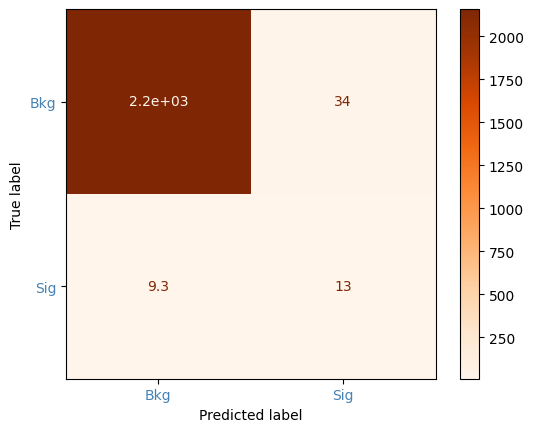

In [18]:
# check out predictions for the best performed design
MLP = MLPClassifier(random_state = seed,
                    hidden_layer_sizes = (8, 4, 2),
                    shuffle = True,
                    max_iter = 1000, # def=200
                    alpha=0.0001,             # def=0.0001
                    activation='relu',  # def=’relu’
                    )

# train the classifer
MLP.fit(X_train_scaled, Y_train)

pred_2022 = MLP.predict(X_test_scaled)

# Confusion Matrix
CM = confusion_matrix(Y_test, pred_2022, labels = MLP.classes_, sample_weight=W_test)
disp = ConfusionMatrixDisplay(CM, display_labels = ['Bkg','Sig'])
disp.plot(cmap='Oranges')
plt.tick_params(labelsize=10, labelcolor='steelblue');

### *4.4 <font color=navy> MLP classification histogram*

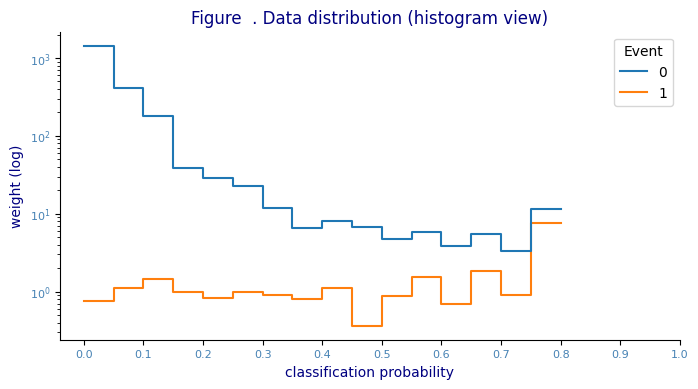

In [19]:
plt.figure(figsize=(8,4))
sns.histplot(df_probs, x=f1max_i[0], weights='Weight', hue='Event', element="step",
             binwidth=0.05, log_scale=[False, True], fill=False)
plt.title(f"Figure  . Data distribution (histogram view)", color='navy', fontsize=12)
plt.xticks(fontsize=8, color='steelblue', ticks=np.arange(0.0,1.1,0.1))
plt.yticks(fontsize=8, color='steelblue')
plt.xlabel('classification probability', color='navy', fontsize=10)
plt.ylabel("weight (log)", color='navy', fontsize=10)
sns.despine();

In [24]:
hist = px.histogram(df_probs, x='(8, 8, 4)', y='Weight', color='Event',
                    opacity=0.5,
                    range_x=[-0.05,1.05],
                    title='Distribution of MLP output',
                    width=800, height=500,
                    template = 'simple_white',
                    histnorm='', histfunc='sum',
                    log_y=True,
                    barmode='overlay',
                    )
hist.update_traces(
                    xbins=dict(size=0.05, start=0.0, end=1.0),
                    #marker=dict(color='white', line=dict(width=2, color=['blue','orange'])),
                    )
hist.show()

In [25]:
# make cut and calculate significance
cut=0.55
design = f1max_i[0]
df = df_probs[['Event','Weight',design]]
selection = df[df[design]>=cut]

W_sig = sum(selection[selection['Event']==1.0]['Weight'])
W_bkg = sum(selection['Weight']) - W_sig
S = (W_sig/np.sqrt(W_bkg)).round(2)
S

2.32

In [ ]:
#@title experiment with Plotly
x0 = df_probs[df_probs['Event']==0]['(8, 8, 4)']
y0 = df_probs[df_probs['Event']==0]['Weight']

x1 = df_probs[df_probs['Event']==1]['(8, 8, 4)']
y1 = df_probs[df_probs['Event']==1]['Weight']

# Build figure
fig = go.Figure()

# Add first scatter trace with medium sized markers
fig.add_trace(go.Histogram(
                          x=x0, y=y0,
                          opacity=0.5,
                          marker=dict(
                                      color='White',
                                      #size=0.05,
                                      line=dict(color='Blue', width=2)
                                      ),
                          name='Bkg'
                          )
              )

# Add first scatter trace with medium sized markers
fig.add_trace(go.Histogram(
                          x=x1, y=y1,
                          opacity=0.5,
                          marker=dict(
                                      color='White',
                                      #size=0.05,
                                      line=dict(color='Orange', width=2)
                                      ),
                          name='Sig'
                          )
              )

fig.update_layout(width=800, height=500, template = 'simple_white',)
fig.update_traces(xbins=dict(size=0.05, start=0.0, end=1.0))

### 4.5 <font color=navy> *Beyond '(10, 10, 10)' - more neurons*

In [29]:
# upload Probs and Metrics from Colab
df_probs3 = pd.read_csv('/content/drive/My Drive/Diss modelling/df_probs_2022_3.csv',index_col='index')
df_metrics3 = pd.read_csv('/content/drive/My Drive/Diss modelling/df_metrics_2022_3.csv',index_col='index')

# # upload from Jupyter
# df_probs3 = pd.read_csv('G:/My Drive/Diss modelling/df_probs_2022_w3.csv',index_col='index')
# df_metrics3 = pd.read_csv('G:/My Drive/Diss modelling/df_metrics_2022_w3.csv',index_col='index')

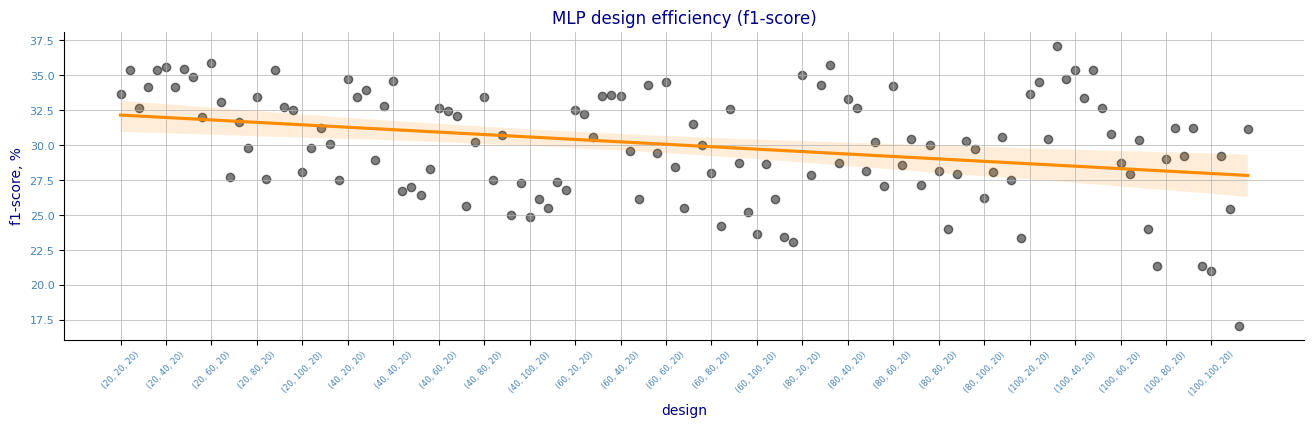

In [31]:
#@title <font color="royalblue">*F1-score*</font> vs. MLP design
plt.figure(figsize=(16,4))
sns.regplot(x = df_metrics3.T.reset_index().index, y = df_metrics3.T['f1-score'],
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "darkorange"});
plt.xlabel('design', color='navy', fontsize=10)
plt.ylabel('f1-score, %', color='navy', fontsize=10)
plt.xticks(ticks = [df_metrics3.T.reset_index().index[t] for t in range(0, len(df_metrics3.T.reset_index().index), 5)],
           labels = [df_metrics3.T.index[t] for t in range(0, len(df_metrics3.T.index), 5)],
           color='steelblue',fontsize=6, rotation=45)
plt.yticks(color='steelblue',fontsize=8)
plt.title('MLP design efficiency (f1-score)',color='navy',fontsize=12)
plt.grid(linewidth=0.5)
sns.despine();

In [32]:
#@title <font color="royalblue">*Find*</font> best performing design (15-25 neurons)
f1max = df_metrics3.T['f1-score'].max()
Prmax = df_metrics3.T['Precision'].max()
Rmax = df_metrics3.T['Recall'].max()
print('Best f1-score: ',f1max)
print('Best precision:',Prmax)
print('Best recall:',Rmax)
f1max_i = df_metrics3.T[df_metrics3.T['f1-score']==f1max].index
Prmax_i = df_metrics3.T[df_metrics3.T['Precision']==Prmax].index
Rmax_i = df_metrics3.T[df_metrics3.T['Recall']==Rmax].index
df_metrics3[[f1max_i[0], Prmax_i[0], Rmax_i[0]]]

Best f1-score:  37.1
Best precision: 27.6
Best recall: 70.30999999999999


,"(100, 20, 80)","(100, 20, 80)","(100, 80, 100)"
index,,,
Accuracy,98.03,98.03,94.67
Precision,27.60,27.60,12.57
Recall,56.61,56.61,70.31
f1-score,37.10,37.10,21.33
S,2.22,2.22,1.52


In [ ]:
# check out predictions for the best performed design
MLP = MLPClassifier(solver = 'adam',
                    activation ='relu',
                    hidden_layer_sizes = (15, 20, 20),
                    shuffle = True,
                    random_state = seed,
                    max_iter = 1000 # def=200
                    )

# train the classifer
MLP.fit(X_train_scaled, Y_train)

pred_15_20_20 = MLP.predict(X_test_scaled)

# Confusion Matrix
CM = confusion_matrix(Y_test, pred_15_20_20, labels = MLP.classes_, sample_weight=W_test)
disp = ConfusionMatrixDisplay(CM, display_labels = ['Bkg','Sig'])
disp.plot(cmap='Oranges')
plt.tick_params(labelsize=10, labelcolor='steelblue');

In [ ]:
hist = px.histogram(df_probs3, x=Prmax_i[0], y='Weight', color='Event',
                    opacity=0.5, range_x=[-0.05,1.05], width=800, height=500,
                    title='Distribution of MLP output',
                    template = 'simple_white', log_y=True, barmode='overlay',
                    )
hist.update_traces(xbins=dict(size=0.05, start=0.0, end=1.0))
hist.show()

Output hidden; open in https://colab.research.google.com to view.

In [27]:
# make cut and calculate significance
def cut_search(df, cut):
    Sign={}
    designs = df.drop(['Event','Weight'], axis=1).columns
    for design in designs:
        df_filt = df[['Event','Weight',design]]
        selection = df_filt[df_filt[design]>=cut]
        W_sig = sum(selection[selection['Event']==1.0]['Weight'])
        W_bkg = sum(selection['Weight']) - W_sig
        S = (W_sig/np.sqrt(W_bkg)).round(2)
        Sign[design]=S

    Sign = pd.DataFrame(Sign,index=['Significance'])
    S_max = Sign.T['Significance'].max()
    return S_max

In [33]:
slider = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1.0,
    step=0.05,
    description='Cut:',
    continuous_update=True,
    orientation='horizontal',
    #readout=True,
    readout_format='.2f',
)

widgets.interact(cut_search, df = widgets.fixed(df_probs3), cut = slider);

interactive(children=(FloatSlider(value=0.5, description='Cut:', max=1.0, step=0.05), Output()), _dom_classes=…

## **5. <font color=navy> Visualisation with feature extraction**

### *5.0 <font color=navy> Scatter plot visualisation*

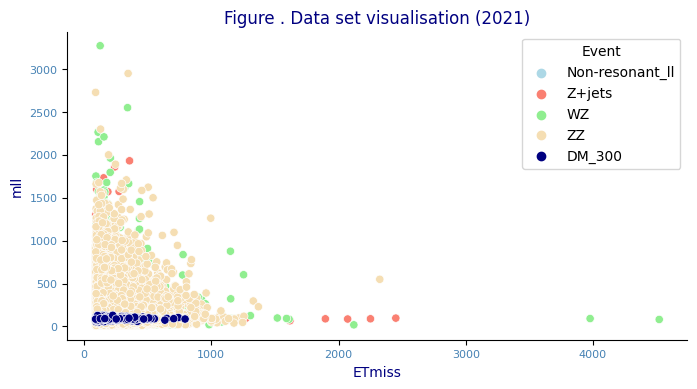

In [93]:
#@title <font color="royalblue">*Visualise*</font> in a scatter plot (static view)
plt.figure(figsize=(8,4))
sns.scatterplot(df_app, x='ETmiss', y='mll', hue='Event', palette=Palette)
plt.xlabel('ETmiss', color='navy', fontsize=10)
plt.ylabel('mll', color='navy', fontsize=10)
plt.xticks(color='steelblue',fontsize=8)
plt.yticks(color='steelblue',fontsize=8)
plt.title('Data selection visualisation',color='navy',fontsize=12)
sns.despine();

### *5.1 <font color=navy> Data pre-processing and scaling*

In [ ]:
# separate subsets: pure data (X), labels (Y) and MC weights (X_weights)
X = df_app.drop(['Event','totalWeight'], axis=1).values
Y = df_app['Event'].values
W_weights = df_app['totalWeight'].values

In [ ]:
# Initialise the Scaler
scaler = StandardScaler()

# Scale the sets
X_scaled = scaler.fit_transform(X)

In [ ]:
# # save scaled data set
# df_scaled = pd.DataFrame(X_scaled)
# df_scaled.to_csv('/content/drive/My Drive/df_scaled.csv', index=False)

### *5.2 <font color=navy> UMAP*

In [ ]:
#@title <font color="salmon">*Don't run*</font> (UMAP transform)
# set 2D UMAP
umap = UMAP(n_components=2, init='random', random_state=0)

# built up embedding
umap_2021 = umap.fit_transform(X_scaled)

In [ ]:
#@title <font color="salmon">*Don't run*</font> (UMAP dataframe update)
# transform the embedding into pandas dataframe...
df_2021_umap = pd.DataFrame(umap_2021)

# add Event column (will be handy for the web app)
df_2021_umap['Event'] = df_2021['Event']
df_2021_umap['totalWeight'] = df_2021['totalWeight']

# ...and save 2D-projection to csv
df_2021_umap.to_csv('/content/drive/My Drive/df_2021_umap.csv', index=False)
#df_2021_umap.to_csv('G:/My Drive/df_2021_umap.csv', index=False)

In [ ]:
#@title <font color="royalblue">*Upload*</font> UMAP dataframe (adjust file location)
# upload the embedding directly from the disk
myfile='/content/drive/My Drive/df_2021_umap.csv'
# myfile='G:/My Drive/df_2021_umap.csv'
df_2021_umap = pd.read_csv(myfile,index_col=None)

df_2021_umap

,0,1,Event,totalWeight
0,6.174164,6.936199,Non-resonant_ll,0.105282
1,8.505915,4.210439,Non-resonant_ll,0.044659
2,4.652369,1.857338,Non-resonant_ll,0.061775
3,3.346834,1.653421,Non-resonant_ll,0.099584
4,6.415687,9.186105,Non-resonant_ll,0.109538
...,...,...,...,...
23525,-0.082944,-2.589686,DM_300,0.078610
23526,6.200602,10.502774,DM_300,0.073187
23527,1.902477,8.052322,DM_300,0.077624
23528,6.150985,10.817308,DM_300,0.075400


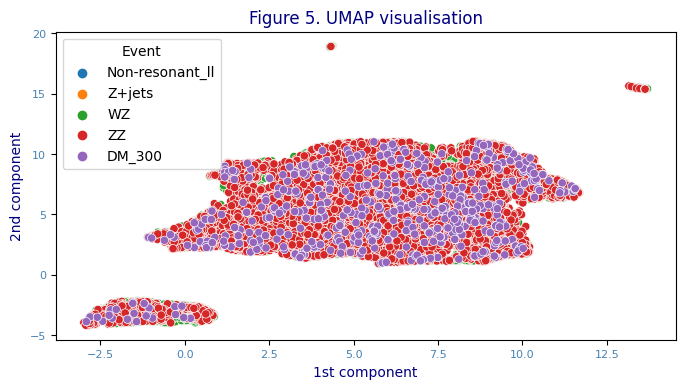

In [ ]:
#@title <font color="royalblue">*Visualise*</font> UMAP embedding (static view)
plt.figure(figsize=(8,4))
sns.scatterplot(df_2021_umap, x='0', y='1', hue='Event')
plt.xlabel('1st component', color='navy', fontsize=10)
plt.ylabel('2nd component', color='navy', fontsize=10)
plt.xticks(color='steelblue',fontsize=8)
plt.yticks(color='steelblue',fontsize=8)
plt.title('Figure 5. UMAP visualisation',color='navy',fontsize=12);

In [ ]:
#@title <font color="royalblue">*Visualise*</font> UMAP embedding (interactive view)
UMAP_2D_2021 = px.scatter(
    df_2021_umap, x='0', y='1',
    color=df_2021.Event,
    labels={'color': 'Event', '0': 'X component', '1': 'Y component'},
    title = 'UMAP scatterplot of Events',
    template = 'plotly_white', #'simple_white',
    width=1200,
    # height=500,
    color_discrete_map={'DM_300':'navy','Non-resonant_ll':'lightblue','Z+jets':'salmon','WZ':'lightgreen','ZZ':'wheat'},
)

UMAP_2D_2021.update_layout(font_family="Segoe Print",
                          font_size=14,
                          font_color="navy",
                          showlegend=True,
                          title_text='2D projection (UMAP)',
                          title_x=0.5, title_y=0.95)

UMAP_2D_2021.update_traces(marker={'line':{'width':1, 'color':'white'},
                                  'size':9})

UMAP_2D_2021.show()

In [ ]:
fig_2d.write_html('G:/My Drive/2D_proj_2021.html')

In [ ]:
# too many features...
fig = px.scatter_matrix(df_2021.drop(['Event','totalWeight'], axis=1), dimensions=df_2021.drop(['Event','totalWeight'], axis=1).columns, color=df_2021.Event)
fig.show()

### *5.3 <font color=navy> PCA*

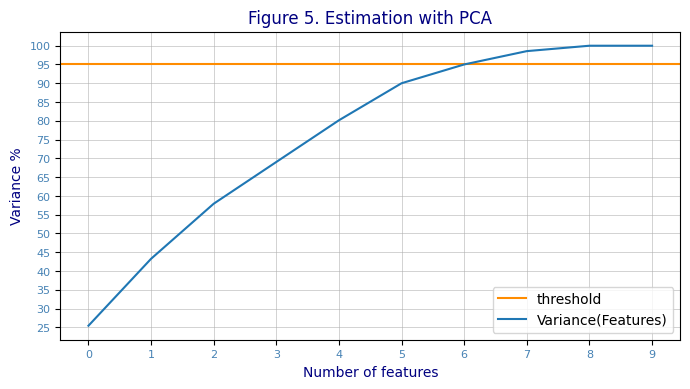

In [ ]:
# estimate the number of principal features with PCA
pca_estimate = PCA(random_state=0, whiten=True)
pca_estimate.fit(X_scaled)
var = np.cumsum(pca_estimate.explained_variance_ratio_*100)

# plotting
plt.figure(figsize=(8,4))
plt.ylabel("Variance %",color='navy',fontsize=10)
plt.yticks(np.arange(20,101,5),color='steelblue',fontsize=8)
plt.xlabel("Number of features",color='navy',fontsize=10)
plt.xticks(np.arange(0,16,1),color='steelblue',fontsize=8)
plt.axhline(95, color="darkorange",label='threshold')
sns.lineplot(data=var,label='Variance(Features)').set_title("Figure 5. Estimation with PCA", color='navy',fontsize=12)
plt.grid(linestyle='-', linewidth=0.4)

In [ ]:
# apply PCA transformation to the data set
pca = PCA(random_state=seed, whiten=True, n_components=2)
PCA_2022 = pca.fit_transform(X_scaled)

In [ ]:
# transform the embedding into pandas dataframe...
df_2022_pca = pd.DataFrame(PCA_2022)

# add Event and Weights columns (will be handy for the web app)
df_2022_pca['Event'] = df_2022['Event']
df_2022_pca['totalWeight'] = df_2022['totalWeight']

# ...and save 2D-projection to csv
df_2022_pca.to_csv('/content/drive/My Drive/Diss modelling/df_2022_pca.csv', index=False)
# df_2021_pca.to_csv('G:/My Drive/df_2021_pca.csv', index=False)

In [ ]:
#@title <font color="royalblue">*Upload*</font> PCA dataframe (adjust file location)
# upload the embedding directly from the disk
myfile='/content/drive/My Drive/Diss modelling/df_2022_pca.csv'
# myfile='G:/My Drive/df_2021_pca.csv'
df_2022_pca = pd.read_csv(myfile,index_col=None)

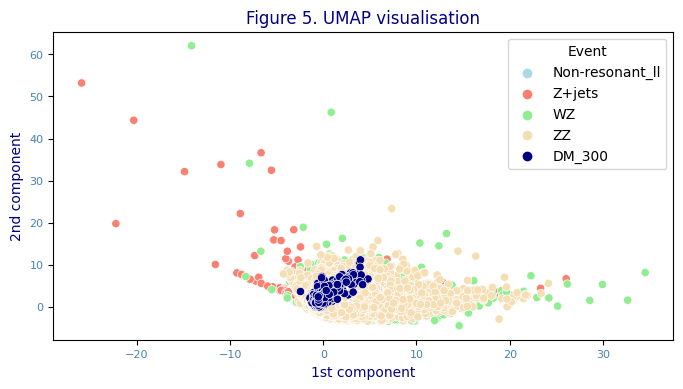

In [ ]:
#@title <font color="royalblue">*Visualise*</font> PCA embedding (static view)
plt.figure(figsize=(8,4))
sns.scatterplot(df_2022_pca, x=0, y=1, hue='Event',
                palette={'Non-resonant_ll':'lightblue','Z+jets':'salmon','WZ':'lightgreen','ZZ':'wheat','DM_300':'navy'})
plt.xlabel('1st component', color='navy', fontsize=10)
plt.ylabel('2nd component', color='navy', fontsize=10)
plt.xticks(color='steelblue',fontsize=8)
plt.yticks(color='steelblue',fontsize=8)
plt.title('Figure 5. PCA visualisation',color='navy',fontsize=12)
sns.despine();

In [ ]:
#@title <font color="royalblue">*Visualise*</font> PCA embedding (interactive view)
fig_pca = px.scatter(
    df_2022_pca, x=0, y=1,
    color=df_2022.Event,
    #labels={'color': 'Event', 0: 'X component', 1: 'Y component'},
    title = 'PCA approximation of Events',
    template = 'plotly_white', #'simple_white',
    width=1000, height=500,
    opacity = 0.5,
    #color_discrete_sequence={'DM_300':'navy','Non-resonant_ll':'lightblue','Z+jets':'salmon','WZ':'lightgreen','ZZ':'wheat'},
)

fig_pca.update_traces(marker={'line':{'width':2, 'color':'white'},
                              'size':9},
                      )
fig_pca.show()

### *5.31 <font color=navy> Weighted PCA*

In [ ]:
len(X_scaled[0])

10

In [ ]:
weights = [[w] for w in X_weights]
weights

In [ ]:
weights = np.array(X_weights)

In [ ]:
weights

In [ ]:
# apply PCA transformation to the data set
wpca = WPCA(n_components=2)
WPCA_2022 = wpca.fit_transform(X_scaled, **{'weights': [X_weights,X_weights]})

ValueError: ignored

In [ ]:
WPCA_2022 = wpca.fit_transform(X_scaled)

KeyboardInterrupt: ignored

In [ ]:
# transform the embedding into pandas dataframe...
df_2022_wpca = pd.DataFrame(WPCA_2022)

# add Event and Weights columns (will be handy for the web app)
df_2022_wpca['Event'] = df_2022['Event']
df_2022_wpca['totalWeight'] = df_2022['totalWeight']

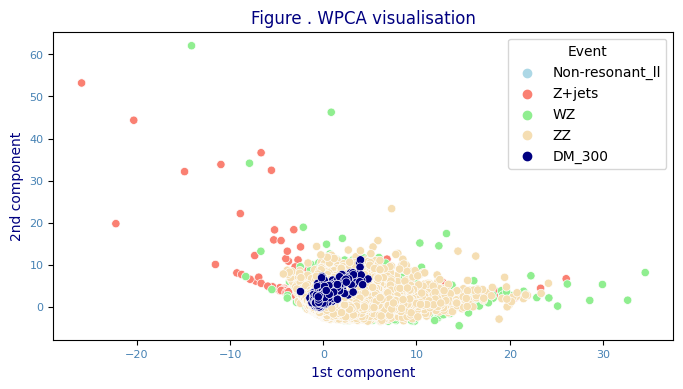

In [ ]:
#@title <font color="royalblue">*Visualise*</font> weighted PCA embedding (static view)
plt.figure(figsize=(8,4))
sns.scatterplot(df_2022_wpca, x=0, y=1, hue='Event',
                palette={'Non-resonant_ll':'lightblue','Z+jets':'salmon','WZ':'lightgreen','ZZ':'wheat','DM_300':'navy'})
plt.xlabel('1st component', color='navy', fontsize=10)
plt.ylabel('2nd component', color='navy', fontsize=10)
plt.xticks(color='steelblue',fontsize=8)
plt.yticks(color='steelblue',fontsize=8)
plt.title('Figure . WPCA visualisation',color='navy',fontsize=12);

### *5.4 <font color=navy> T-SNE*

In [ ]:
# apply t-SNE transformation to the data set
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30)
tsne_2021 = tsne.fit_transform(X_scaled)

In [ ]:
# transform the embedding into pandas dataframe...
df_2021_tsne = pd.DataFrame(tsne_2021)

# add Event and Weights columns (will be handy for the web app)
df_2021_tsne['Event'] = df_2021['Event']
df_2021_tsne['totalWeight'] = df_2021['totalWeight']

# ...and save 2D-projection to csv
df_2021_tsne.to_csv('/content/drive/My Drive/df_2021_tsne.csv', index=False)
# df_2021_tsne.to_csv('G:/My Drive/df_2021_tsne.csv', index=False)

In [ ]:
#@title <font color="royalblue">*Upload*</font> t-SNE dataframe (adjust file location)
# upload the embedding directly from the disk
myfile='/content/drive/My Drive/Diss modelling/df_2021_tsne.csv'
# myfile='G:/My Drive/df_2021_pca.csv'
df_2021_tsne = pd.read_csv(myfile,index_col=None)

In [ ]:
# visualise TSNE embedding (interactive view)
fig_tsne = px.scatter(
    df_2021_tsne, x='0', y='1',
    color=df_2021_tsne.Event,
    labels={'color': 'Event', '0': 'X component', '1': 'Y component'},
    title = 'PCA approximation of Events',
    template = 'plotly_white', #'simple_white',
    width=1000,
    height=500,
    color_discrete_map=Palette,
)

fig_tsne.update_traces(marker={'line':{'width':1, 'color':'white'},
                              'size':10},
                      )
fig_tsne.show()

## **6. <font color=navy> MLP visualisation**

In [ ]:
# number of input features
f=10

# number of hidden layers (1 to 3)
Nhl = 1

# number of nods in the hidden layers
hl1=1
hl2=2
hl3=4

# number of output nods = 2
o=2

In [ ]:
#@title <font color="coral">*Construct*</font>  MLP

# initiate label array with input features
Label = [f'F{i+1}' for i in range(f)]
# for i in range(f):
#     Label.append(f'F{i+1}')
HL1 = [f'HL1.{i+1}' for i in range(hl1)]
HL2 = [f'HL2.{i+1}' for i in range(hl1)]
HL3 = [f'HL3.{i+1}' for i in range(hl1)]
O = ['Signal', 'Background']
# for i in range(l):
#     Label.append(f'L{i+1}')
# for i in range(o):
#     Label.append(f'O{i+1}')
Label = Label + HL1 + HL2 + HL3 + O

# x
if Nhl == 1:
    X = f*[0.1] + hl1*[0.5] + o*[0.9]
elif Nhl == 2:
    X = f*[0.0] + hl1*[0.35] + hl2*[0.65] + o*[1.0]
elif Nhl == 3:
    X = f*[0.0] + hl1*[0.25] + hl2*[0.5] + hl3*[0.75]+ o*[1.0]

# y
Y = [(i+1)/(f+1) for i in range(f)]  # initialise with features' Y-coordinates
Yhl1 = [(i+1)/(hl1+1) for i in range(hl1)]
Yhl2 = [(i+1)/(hl2+1) for i in range(hl2)]
Yhl3 = [(i+1)/(hl3+1) for i in range(hl3)]
Yo = [(i+1)/(o+1) for i in range(o)]
Y = Y + Yhl1 + Yhl2 + Yhl3 + Yo

# source
SourceF = np.array([hl1*[i] for i in range(f)]).flatten() # links 'features - HL1'
if Nhl==1:
    SourceHL1 = np.array([o*[i] for i in range(f,f+hl1)]).flatten()
    Source = np.concatenate((SourceF,SourceHL1))
elif Nhl==2:
    SourceHL1 = np.array([hl2*[i] for i in range(f,f+hl1)]).flatten()
    SourceHL2 = np.array([o*[i] for i in range(f+hl1,f+hl1+hl2)]).flatten()
    Source = np.concatenate((SourceF,SourceHL1,SourceHL2))
elif Nhl==3:
    SourceHL1 = np.array([hl2*[i] for i in range(f,f+hl1)]).flatten()
    SourceHL2 = np.array([hl3*[i] for i in range(f+hl1,f+hl1+hl2)]).flatten()
    SourceHL3 = np.array([o*[i] for i in range(f+hl1+hl2,f+hl1+hl2+hl3)]).flatten()
    Source = np.concatenate((SourceF,SourceHL1,SourceHL2,SourceHL3))
print(Source)
# target
Target1 = f*[i for i in range(f,f+hl1)] # links 'features - HL1'
if Nhl==1:
    TargetO = hl1*[i for i in range(f+hl1,f+hl1+o)]
    Target = Target1 + TargetO
elif Nhl==2:
    Target2 = hl1*[i for i in range(f+hl1,f+hl1+hl2)]
    TargetO = hl2*[i for i in range(f+hl1+hl2,f+hl1+hl2+o)]
    Target = Target1 + Target2 + TargetO
elif Nhl==3:
    Target2 = hl1*[i for i in range(f+hl1,f+hl1+hl2)]
    Target3 = hl2*[i for i in range(f+hl1+hl2,f+hl1+hl2+hl3)]
    TargetO = hl3*[i for i in range(f+hl1+hl2+hl3,f+hl1+hl2+hl3+o)]
    Target = Target1 + Target2 + Target3 + TargetO

# value
#Value = [1]*len(Source)
Value = [round(random.uniform(0.0001, 1),2) for _ in range(len(Source))]

# line color
Pos = random.sample(Value, int(len(Source)/2))
Color = []
Weights = []
for v in Value:
    if v in Pos:
        Color.append('lightsalmon')
        Weights.append(v)
    else:
        Color.append('lightblue')
        Weights.append(-v)

# # links' info
# Weights = []
# for v in Value:
#     Weights.append(round((v-100)/100,2))


[ 0  1  2  3  4  5  6  7  8  9 10 10]


In [ ]:
Sfolly = np.array([Source[-1]+1,Source[-1]+2,Source[-1]+3]).flatten()
Sfolly

array([11, 12, 13])

In [ ]:
#@title <font color="royalblue">*Visualise*</font>  MLP
fig = go.Figure(go.Sankey(
    arrangement='fixed',
    node=dict(
        pad = 100000,
        thickness = 10,
        label = Label,
        x = X,
        y = Y
        ),
    link=dict(
        arrowlen=25,
        color=Color,
        customdata=Weights,
        hovertemplate = 'weight is %{customdata} <extra></extra>',
        source = Source,
        target = Target,
        value = Value
        )
))

fig.show()

## **7. <font color=navy> SVM modelling**

In [94]:
# default run SVM
SVM = SVC(kernel='rbf', random_state=seed)
SVM.fit(X_train_scaled, Y_train)


SVC(random_state=84)

In [95]:
pred_svm = SVM.predict(X_test_scaled)

In [99]:
f1_score = f1_score(Y_test, pred_svm, sample_weight=W_test)*100
# acc = accuracy_score(Y_test, pred)*100
# prec = precision_score(Y_test, pred)*100
# recall = recall_score(Y_test, pred)*100
f1_score

36.27575236904171

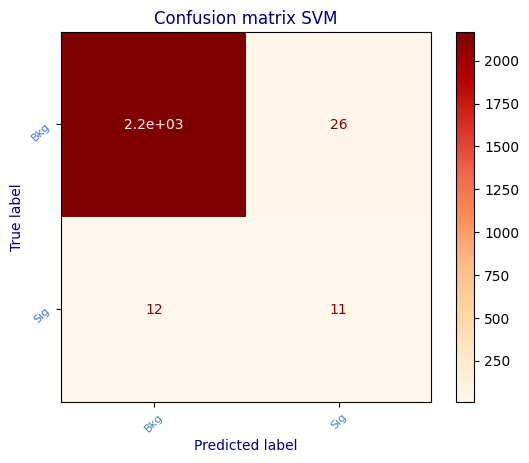

In [100]:
# Confusion Matrix SVM
CM_svm = confusion_matrix(Y_test, pred_svm, labels = SVM.classes_, sample_weight=W_test)
disp = ConfusionMatrixDisplay(CM_svm, display_labels = ['Bkg','Sig'])
disp.plot(cmap='OrRd')
plt.title("Confusion matrix SVM", color='navy', fontsize=12)
plt.xlabel("Predicted label", color='navy', fontsize=10)
plt.ylabel("True label", color='navy', fontsize=10)
plt.yticks(rotation=45, fontsize=8, color='royalblue')
plt.xticks(rotation=45, fontsize=8, color='steelblue');